<a href="https://colab.research.google.com/github/SotaYoshida/Lecture_DataScience/blob/2021/notebooks/Python_chapter_WebScraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web操作・スクレイピング

Webから情報を抽出・整形・解析したり、  
ブラウザ上での特定の操作を自動化する、といったことも  
Pythonでは比較的容易に実行することができる。

Web上にある情報にアクセスしたりする方法は色々あるが、大まかには２つに分類され

1. プログラムでWebページにアクセスして中身(HTML)を読み、そこから情報を抽出する方法
2. ブラウザをプログラムに操作させて特定の作業を実行する方法

この章では、とくに1.のWebから情報を抽出すること(スクレイピング)に絞ってそのエッセンスを紹介する。  
HTMLとは、Webページを作るための言語のことで、  
みなさんが普段からアクセスするWebページの多くは、  
HTMLで記述されています。


Webから情報を抽出したりする際、共通して言える注意点を述べておく:
* **対象とするページの利用規約を必ず確認する**  
規約でスクレイピングを禁止しているページがある (例: Amazon, Twitter, Instagram, facebook, 金融系などなど)  
    禁止している場合でも、APIが提供されている場合があります  
    ※APIはApplication Programming Interfaceの略です。  
    今の場合、大雑把にはデータ提供用の窓口とでも思ってください.

* **サーバーに負荷をかけない**  
    規約で特にスクレイピングを禁止していない場合でも、過度なアクセスをしてはいけません。  
    (どこかの大学の学習支援システムみたいに落ちてしまったら大変です)   
    過度なアクセスは、悪意のあるDos攻撃とみなされてアクセスを制限されたり、  
    最悪の場合、偽計業務妨害罪などの罪に問われる可能性があります。






## 国立感染症研究所からのインフルエンザの感染報告者数の取得


スクレイピングを可能とするライブラリは多数存在する。  
代表的なものは```requests```,```urllib```,```BeautifulSoup4```などなど。

以下では```requests```を使いますが、JavaScriptの実行などがないページならこれでだいたい十分かと思います.  
なお、BeutifulSoup4を使うと、HTMLを構文解析して、  
タグなどを取り除くという操作が比較的容易に行えます。

[国立感染症研究所のインフルエンザ流行レベルマップ](https://nesid4g.mhlw.go.jp/Hasseidoko/Levelmap/flu/)から  
各週のインフルエンザ患者数を抽出する以下のコードを実行してみましょう。

ややadhocな実装ですが、以下の方針で情報を取得します。
1. URL
https://nesid4g.mhlw.go.jp/Hasseidoko/Levelmap/flu/
にアクセスしてページ構造をなんとなく把握する
2. 予め決めた年・週の区間に対してループを回して、対応するURLにアクセスする
3. ページにアクセスして、HTMLを取得する ```requests.get(url)```
4. HTMLをテキストに変換して、[患者報告数]という語句のあとの文字列から数値を取得し、患者報告数の絶対数だとみなす


In [ ]:
import requests
!pip install cchardet
import cchardet
import time
import re #正規表現というものを使うためのモジュール

def exnum(a): #文字列から数値を抽出する関数
    pattern = r'(\d{1,3}(,\d{3})*)'
    return re.findall(pattern,a)

# 7を"07"といった表現に直す関数
def week_str(week):
    if week < 10:
        return "0"+str(week)
    else:
        return str(week)

#スクレイピングする区間の指定
years = range(2016,2017)
#years = range(2013,2020)
sw = 35; ew = 28

weeks = [j for j in range(sw,53)] + [i for i in range(1,ew)]
hit =0 
for s_year in years: # s_yearは○○-△△年シーズンの○○に相当
    tlist = []
    for week in weeks:
        c_week = week_str(week)
        tw=""
        if s_year < 2007:
            tw= str(c_week)            
        if week <=ew :
            c_year = str(s_year+1)
        else:
            c_year = str(s_year)
        time.sleep(0.5) ###サイトに負荷をかけないように0.5秒スリープ(なにもしない)
        url = 'https://nesid4g.mhlw.go.jp/Hasseidoko/Levelmap/flu/'+str(s_year)+'_'+str(s_year+1)+'/'+c_year+'_'+c_week+'/jmap'+tw+'.html'
        ctext = str(c_year)+"年"+c_week+"週目: "
        num = ""
        try : 
            response = requests.get(url) #urlにアクセスしてhtmlを取得する
            # htmlの文字コードを判別する
            #response.encoding = response.apparent_encoding ## 遅いので非推奨
            response.encoding = cchardet.detect(response.content)["encoding"] #代わりにcchardetモジュールを使用 
            lines = response.text           #htmlをテキスト(文字列)に変換
            tmp = lines.split("患者報告数")  #"患者報告数"という文字列以降のテキストを取得
            num = exnum(tmp[1][:20])[0] #そこから20文字くらい読んで、その中に含まれる数値を取得する
            try :
                if type(num) is tuple: #数値が複数ある場合は0番目を患者数とみなす
                    num = num[0]
                ctmp = str( int(num.replace(",","")))
                ctext += ctmp
            except:
                print("error")
        except:
            continue
        tlist += [ ctext  ]     
    print(tlist)


['2016年44週目: 2903', '2016年45週目: 4133', '2016年46週目: 6843', '2016年47週目: 8843', '2016年48週目: 12334', '2016年49週目: 16404', '2016年50週目: 24857', '2016年51週目: 41428', '2016年52週目: 41438', '2017年01週目: 52082', '2017年02週目: 75576', '2017年03週目: 142144', '2017年04週目: 195501', '2017年05週目: 189231', '2017年06週目: 141666', '2017年07週目: 118696', '2017年08週目: 83714', '2017年09週目: 67273', '2017年10週目: 55004', '2017年11週目: 50976', '2017年12週目: 38231', '2017年13週目: 33608', '2017年14週目: 25048', '2017年15週目: 19730', '2017年16週目: 20127', '2017年17週目: 15467', '2017年18週目: 10001', '2017年19週目: 6786', '2017年20週目: 5184', '2017年21週目: 3344', '2017年22週目: 2100']


実は、このコードでは全てのデータを完全に抽出することは出来ていない。  
これはコードの"対応力"の問題でもある。  
実際、ホームページの階層構造を解析するコードにすれば  
URLの取得等の精度を改善することもできる。

一方で、以下のようにデータのフォーマットが統一できてないことも原因といえる。

* 2007年以前と以降とで、urlの命名規則が微妙に変更されている(上のコードではこれには対応した)
* 幾つかの週では[患者報告数]ではなく、  
[定点あたり報告数のみ]の記載となっていて、  
保健所数を別途取得しなければ絶対数が計算できない。
* 2016年の01週は、[患年者報告数]となっていて  
誤字がある場合への例外処理が別途必要になる

一方、以下で扱うe-Statは、河野太郎 行政改革担当大臣が  
>各省庁がネット上で公開する統計を機械判読可能にするために、データの表記方法を統一させます。「政府統計の総合窓口（e-Stat）」で本日から１２月１日までの間、表記方法案に関する意見照会を行います。研究者をはじめ、皆様のご意見をお待ちしています。

との旨を先日(2020年11月25日)表明し、データのフォーマットの統一化が進められるようです。


## e-Statのデータを取得する

[政府統計の総合窓口(e-Stat)](https://www.e-stat.go.jp/)は  
日本の各府省が公表する統計データを一つにまとめた、   
政府統計のポータルサイトです。

e-Statでは[API機能](https://www.e-stat.go.jp/api/)(ユーザー登録が必要)が提供されていて、  
指定されたURLに対してリクエストを送信することで各APIを利用することが出来ます。




### 準備1 e-Statの登録






以降の内容でも、e-StatのAPI機能を使用するため予めe-Statへの登録が必要です。

国内のデータを使って最終課題に取り組みたいという方は  
ここに記載の手順にならって登録しておきましょう。

1. まず[こちら](https://www.e-stat.go.jp/mypage/user/preregister)のページからメールアドレス(Gmailを推奨します)を入力し、届いたメールから本登録を行う  
このとき、gmailアカウントによる認証をオンにしておくと、以後のログインが楽。
2. [ログインページ](https://www.e-stat.go.jp/mypage/login)からログインし、
右上の[マイページ]に遷移
<img src="https://drive.google.com/uc?export=view&id=1NHMQ8GnJ6n6hSaUAIFgOGyRc5Z55Enxj" width = 70%>
3. [API機能(アプリケーションID発行)]に遷移する
4. 以下の例にならって、名称とURLを入力し、発行ボタンを押す
<img src="https://drive.google.com/uc?export=view&id=100w2nmie7ZD6PliQVbjAHIt7o5gaBciN" width = 80%>

5. [appId]に生成された文字列を、どこかに控えておく(**appIdを他人と共有してはいけません**)


### 準備2 Pandas e-Statのインストール


さて、e-Statへの登録ができたでしょうか。  

早速e-Statにあるデータをどんどん抽出したい  
...のですが、[マニュアル](https://www.e-stat.go.jp/api/sites/default/files/uploads/2019/07/API-specVer3.0.pdf)を理解してAPIに適切なリクエストを送るというのは、  
それ自体がややハードルが高いかと思います。

そこで、このノートブックでは[simaki](https://github.com/simaki)氏が作った  
Python用のライブラリ[Pandas e-Stat](https://github.com/simaki/pandas-estat)を使用することにします。  
同氏によるQiitaの解説記事→https://qiita.com/simaki/items/05cc242d27b4e6781d19

まずはインストール&インポートします。



In [ ]:
!pip install pandas-estat
import pandas as pd
## import pandas_estat 
# 以降では、pandas_estat内の関数は個別にimportすることにする (そうすると短い名前で使える)

#実行時の依存関係のエラーは当面問題ない(はず)

     |████████████████████████████████| 61kB 5.1MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


次に```pandas_estat```からAPIを使用するためのIDを指定します

In [ ]:
from pandas_estat import set_appid
appID = "honyarara" # 引用符内を準備1で発行したappidに置き換える
set_appid(appID) 

## Pandas e-Statを使ってみよう

ライブラリを使ってみましょう.  
```read_statslist()```関数の引数に"政府統計コード"を指定することで、  
該当する統計データの一覧を```pandas.DataFrame```形式で取得することができます。  
[政府統計コードの一覧はこちら](https://www.e-stat.go.jp/help/stat-search-3-5)


政府統計コードそのものの一覧をdataframe形式取得するコードはそのうち書くつもりです。  


それでは、さっそくPandas e-statを使ってみましょう。  
以下では、例にならって「サービス産業動向調査」の結果を抽出してみることにしましょう。

In [ ]:
from pandas_estat import read_statslist
statslist = read_statslist("00200544")  # サービス産業動向調査
print(statslist)

      TABLE_INF STAT_CODE  ... SUB_CATEGORY_CODE SUB_CATEGORY
0    0003179100  00200544  ...                02         需給流通
1    0003179101  00200544  ...                02         需給流通
2    0003085562  00200544  ...                02         需給流通
3    0003085612  00200544  ...                02         需給流通
4    0003090498  00200544  ...                02         需給流通
..          ...       ...  ...               ...          ...
137  0003412789  00200544  ...                02         需給流通
138  0003412790  00200544  ...                02         需給流通
139  0003412791  00200544  ...                02         需給流通
140  0003412792  00200544  ...                02         需給流通
141  0003412793  00200544  ...                02         需給流通

[142 rows x 35 columns]


次に、これらのデータがどうやって分類されているのかを調べてみましょう。  
列(column)を表示してみると

In [ ]:
print(statslist.columns)

Index(['TABLE_INF', 'STAT_CODE', 'STAT_NAME', 'GOV_ORG_CODE', 'GOV_ORG_NAME',
       'TABULATION_CATEGORY', 'TABULATION_SUB_CATEGORY1',
       'TABULATION_SUB_CATEGORY2', 'TABULATION_SUB_CATEGORY3',
       'TABULATION_SUB_CATEGORY4', 'TABULATION_SUB_CATEGORY5',
       'TABULATION_CATEGORY_EXPLANATION',
       'TABULATION_SUB_CATEGORY_EXPLANATION1',
       'TABULATION_SUB_CATEGORY_EXPLANATION2',
       'TABULATION_SUB_CATEGORY_EXPLANATION3',
       'TABULATION_SUB_CATEGORY_EXPLANATION4',
       'TABULATION_SUB_CATEGORY_EXPLANATION5', 'NO', 'TITLE',
       'TABLE_EXPLANATION', 'TABLE_CATEGORY', 'TABLE_SUB_CATEGORY1',
       'TABLE_SUB_CATEGORY2', 'TABLE_SUB_CATEGORY3', 'CYCLE', 'SURVEY_DATE',
       'OPEN_DATE', 'SMALL_AREA', 'COLLECT_AREA', 'OVERALL_TOTAL_NUMBER',
       'UPDATED_DATE', 'MAIN_CATEGORY_CODE', 'MAIN_CATEGORY',
       'SUB_CATEGORY_CODE', 'SUB_CATEGORY'],
      dtype='object')


例えば、```CYCLE```(周期)というものがあるので、  
CYCLEが"月次"(月ごと)になっているデータだけをピックアップして、  

In [ ]:
statslist = statslist[statslist.CYCLE == "月次"] 


その```TABLE_INF```(統計表ID)と```TITLE```(タイトル)だけを表示してみましょう

In [ ]:
statslist[["TABLE_INF", "TITLE"]]

,TABLE_INF,TITLE
2,0003085562,事業所・企業等の産業（中分類）別売上高，従業上の地位別事業従事者数（月次）【2013年1月～】
5,0003191203,事業活動の産業（中分類）別売上高（月次）【2013年1月～】
7,0003085489,事業活動の産業（中分類）別需要の状況【2013年1月～2016年12月】
8,0003085521,事業活動の産業（中分類），事業所・企業等の産業（中分類）別売上高（月次）【2013年1月～12月】
10,0003094573,事業活動の産業（一部中分類），事業所・企業等の産業（一部中分類）別売上高（月次）【2013年...


```TABLE_INF```の数値が[統計表ID]と呼ばれるものです。

ではこの中から"事業活動の産業（中分類）別売上高（月次）【2013年1月～】"を読み出してみましょう。  
それには```read_statsdata```という関数が用意されているので、  
引数に```TABLE_INF```(統計表ID)を入力すると...

In [ ]:
from pandas_estat import read_statsdata 
df = read_statsdata("0003191203")  
print(df)

     tab_code      表章項目 cat01_code 事業活動の産業  ...    時間軸（月次） unit     value annotation
0         001  売上高（収入額）      00000      合計  ...    2013年1月  百万円  27331888        NaN
1         001  売上高（収入額）      00000      合計  ...    2013年2月  百万円  27395304        NaN
2         001  売上高（収入額）      00000      合計  ...    2013年3月  百万円  35140562        NaN
3         001  売上高（収入額）      00000      合計  ...    2013年4月  百万円  28676427        NaN
4         001  売上高（収入額）      00000      合計  ...    2013年5月  百万円  28648626        NaN
...       ...       ...        ...     ...  ...        ...  ...       ...        ...
4459      001  売上高（収入額）      20000     その他  ...    2020年5月  百万円    753034        NaN
4460      001  売上高（収入額）      20000     その他  ...    2020年6月  百万円    841843        NaN
4461      001  売上高（収入額）      20000     その他  ...  2020年7月 p  百万円    809144        NaN
4462      001  売上高（収入額）      20000     その他  ...  2020年8月 p  百万円    798929        NaN
4463      001  売上高（収入額）      20000     その他  ...  2020年9月 p  百万円  

これで、データを抽出することができました。

In [ ]:
df.columns

Index(['tab_code', '表章項目', 'cat01_code', '事業活動の産業', 'area_code', '地域',
       'time_code', '時間軸（月次）', 'unit', 'value', 'annotation'],
      dtype='object')

もう属性を少し絞ってみましょう。

dataframeの"事業活動の産業"列にどんなものがあるかを抽出し、  
```set```関数を使って重複を除くと...

In [ ]:
set(df["事業活動の産業"])

{'37通信業',
 '38放送業',
 '39情報サービス業',
 '4*航空運輸業，郵便業（信書便事業を含む）',
 '40インターネット附随サービス業',
 '41映像・音声・文字情報制作業',
 '42鉄道業',
 '43道路旅客運送業',
 '44道路貨物運送業',
 '45水運業',
 '47倉庫業',
 '48運輸に附帯するサービス業',
 '68不動産取引業',
 '69不動産賃貸業・管理業',
 '70物品賃貸業',
 '72専門サービス業（他に分類されないもの）\u3000（※「純粋持株会社」（平成25年１月以降）を除く）',
 '73広告業',
 '74技術サービス業（他に分類されないもの）',
 '75宿泊業',
 '76飲食店',
 '77持ち帰り・配達飲食サービス業',
 '78洗濯・理容・美容・浴場業',
 '79その他の生活関連サービス業\u3000（※「家事サービス業」を除く）',
 '80娯楽業',
 '82aうち社会教育，職業・教育支援施設',
 '82bうち学習塾，教養・技能教授業',
 '82その他の教育，学習支援業',
 '83医療業',
 '84保健衛生\u3000（※「保健所」を除く）',
 '85社会保険・社会福祉・介護事業\u3000（※「社会保険事業団体」（平成25年１月以降）及び「福祉事務所」を除く）',
 '88廃棄物処理業',
 '89自動車整備業',
 '90機械等修理業（別掲を除く）',
 '91職業紹介・労働者派遣業',
 '92その他の事業サービス業',
 '95その他のサービス業',
 'その他',
 'サービス産業計',
 '合計',
 'Ｇ情報通信業',
 'Ｈ運輸業，郵便業',
 'Ｋ不動産業，物品賃貸業',
 'Ｌ学術研究，専門・技術サービス業\u3000（※「学術・開発研究機関」（平成25年１月以降）及び「純粋持株会社」（平成25年１月以降）を除く）',
 'Ｍ宿泊業，飲食サービス業',
 'Ｎ生活関連サービス業，娯楽業\u3000（※「家事サービス業」を除く）',
 'Ｏ教育，学習支援業\u3000（※「学校教育」を除く）',
 'Ｐ医療，福祉（※「保健所」、「社会保険事業団体」（平成25年１月以降）及び「福祉事務所」を除く）',
 'Ｒサービス業（他に分類されないもの）\u3000（

"42鉄道業"を見てみましょう。  

In [ ]:
ndf = df[df["事業活動の産業"] == "42鉄道業"] #dfの中の、"事業活動の産業欄が"42鉄道業"のものを抽出し、ndfと名前をつける

ndf = ndf[ndf["時間軸（月次）"].str.endswith("月")]
ndf["時間軸（月次）"] = pd.to_datetime(ndf["時間軸（月次）"], format="%Y年%m月")
ndf = ndf.sort_values("時間軸（月次）")

#必要なところだけ抽出すると...
ndf[["時間軸（月次）", "value", "unit"]]

    tab_code      表章項目 cat01_code 事業活動の産業  ...  時間軸（月次） unit   value annotation
837      001  売上高（収入額）      03010   42鉄道業  ...  2013年1月  百万円  583438        NaN
838      001  売上高（収入額）      03010   42鉄道業  ...  2013年2月  百万円  529656        NaN
839      001  売上高（収入額）      03010   42鉄道業  ...  2013年3月  百万円  644219        NaN
840      001  売上高（収入額）      03010   42鉄道業  ...  2013年4月  百万円  627287        NaN
841      001  売上高（収入額）      03010   42鉄道業  ...  2013年5月  百万円  581344        NaN
..       ...       ...        ...     ...  ...      ...  ...     ...        ...
922      001  売上高（収入額）      03010   42鉄道業  ...  2020年2月  百万円  579211        NaN
923      001  売上高（収入額）      03010   42鉄道業  ...  2020年3月  百万円  518402        NaN
924      001  売上高（収入額）      03010   42鉄道業  ...  2020年4月  百万円  254320        NaN
925      001  売上高（収入額）      03010   42鉄道業  ...  2020年5月  百万円  234375        NaN
926      001  売上高（収入額）      03010   42鉄道業  ...  2020年6月  百万円  314957        NaN

[90 rows x 11 columns]


,時間軸（月次）,value,unit
837,2013-01-01,583438,百万円
838,2013-02-01,529656,百万円
839,2013-03-01,644219,百万円
840,2013-04-01,627287,百万円
841,2013-05-01,581344,百万円
...,...,...,...
922,2020-02-01,579211,百万円
923,2020-03-01,518402,百万円
924,2020-04-01,254320,百万円
925,2020-05-01,234375,百万円


図を描いてみよう

In [ ]:
import matplotlib.pyplot as plt
!pip install japanize-matplotlib 
import japanize_matplotlib 
import matplotlib.dates as mdates

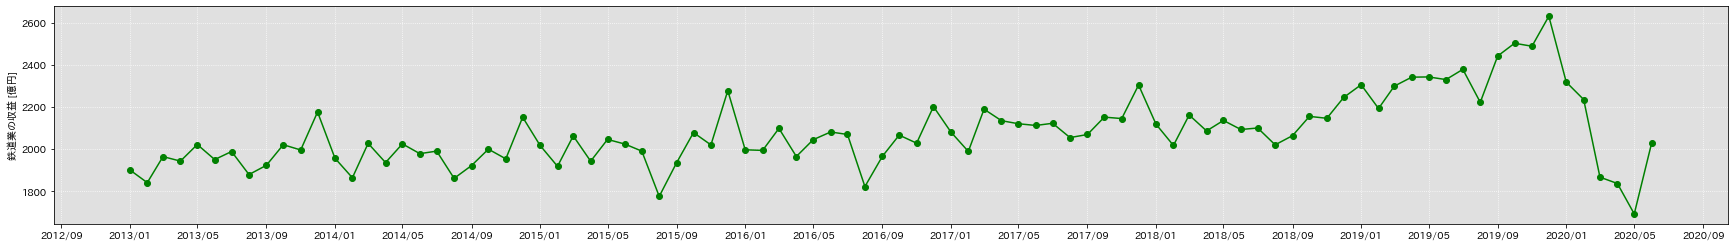

In [ ]:
x = ndf["時間軸（月次）"].values
y = ndf["value"].values.astype(float) * 1.e-2  # XX億円に換算

fig = plt.figure(figsize=(30, 4))
ax = fig.add_subplot(111)  
ax.set_facecolor("#e0e0e0")
ax.set_ylabel("鉄道業の収益 [億円]")
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1, 13, 4)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y/%m"))
ax.grid(True,axis="both",color="w", linestyle="dotted", linewidth=0.8)
ax.plot(x,y,marker="o",color="green")
plt.show()
plt.close()

新型コロナウイルスの感染拡大を受けて2020年の1月ごろから  
緊急事態宣言の解除(5月25日)まで、大幅に収益が減っていることが分かる。



---



### 備考

あらかじめ興味のあるデータ,分類・属性等がわかっている場合は、  
上記のコードの対応するIDなどを変更すればよいし  
コードを拡張して、データ,分類・属性等の一覧表などを適宜表示しながら、  
特定のキーワードを含むものに絞ってデータを取得したりもできる。

ちなみに、プルダウンでデータ,分類・属性等を選んでプロットする、  
といったようにGoogle Colab.上で自分だけのe-Stat分析ツールを作ることもできる  
(最終課題案にも入れる予定)
